# Project

## Enviroment Install

In [1]:
!pip install kaggledatasets

     |████████████████████████████████| 58 kB 620 kB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 548 kB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=15f7c1dc29cd577b996478f123bf40a00c32cfdf1a86260bbb9e09c6b359a757
  Stored in directory: /root/.cache/pip/wheels/77/47/e4/44a4ba1b7dfd53faaa35f59f1175e123b213ff401a8a56876b
Successfully built kaggle


In [3]:
!pip install tensorflow

     |████████████████████████████████| 394.3 MB 13 kB/s /s eta 0:00:01   |█▊                              | 20.6 MB 19.9 MB/s eta 0:00:19
     |████████████████████████████████| 2.9 MB 97.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 357 kB/s  eta 0:00:01
     |████████████████████████████████| 14.8 MB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 99.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 84.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 131 kB/s  eta 0:00:01
     |████████████████████████████████| 6.0 MB 68.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 70.0 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 98.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 696 kB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 64.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 68.8 MB/s eta 0:00:01
     |█████████████████████████████

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
from zipfile import ZipFile
from os import listdir
import tensorflow as tf
import glob
import re
from os.path import isfile, join
from os import walk
#from skimage import measure
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import itertools
import torchvision.transforms as transforms

## Data Processing

### Data Download

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!mkdir task_datasets
!kaggle competitions download -c "gan-getting-started" -p "./task_datasets/"

 94%|█████████████████████████████████████▌  | 345M/367M [00:04<00:00, 44.4MB/s]
100%|████████████████████████████████████████| 367M/367M [00:07<00:00, 48.5MB/s]


In [ ]:
!unzip ./task_datasets/gan-getting-started.zip

In [21]:
PATH_PREV = "./task_datasets/"
!mkdir $PATH_PREV
PHOTO_PATH = PATH_PREV + "photo_tfrec/"
MONET_PATH = PATH_PREV + "monet_tfrec/"


mkdir: cannot create directory ‘./task_datasets/’: File exists


In [15]:
for filename in listdir(PATH_PREV):
  if isfile(join(PATH_PREV, filename)) and re.match("photo(.*)zip", filename)is not None:
    with ZipFile(PATH_PREV + filename, 'r') as zipObj:
      zipObj.extractall(path=PHOTO_PATH)
for filename in listdir(PATH_PREV):
  if isfile(join(PATH_PREV, filename)) and re.match("monet(.*)zip", filename)is not None:
    with ZipFile(PATH_PREV + filename, 'r') as zipObj:
      zipObj.extractall(path=MONET_PATH)

In [22]:
PHOTO_PATH

'./task_datasets/photo_tfrec/'

In [23]:
photos = listdir(PHOTO_PATH)
photos.sort()
photos = [PHOTO_PATH + i for i in photos]
monets = listdir(MONET_PATH)
monets.sort()
monets = [MONET_PATH + i for i in monets]

In [24]:
monet_len = 0
for fn in monets:
  for record in tf.data.TFRecordDataset(fn):
     monet_len += 1
photo_len = 0
for fn in photos:
  for record in tf.data.TFRecordDataset(fn):
     photo_len += 1

In [25]:
monet_len, photo_len

(300, 7038)

In [26]:
IMAGE_SIZE = [256, 256]


def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
    
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [27]:
def datasetGetAndTransform(augment=None, repeat=None, shuffle=True, batch_size=1):
    global monets, photos
    monet_ds = load_dataset(monets)
    photo_ds = load_dataset(photos)
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    #monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    #photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    #monet_ds = monet_ds.cache()
    #photo_ds = photo_ds.cache()
    #monet_ds = monet_ds.prefetch()
    #photo_ds = photo_ds.prefetch()
    return monet_ds, photo_ds

### Data Preprocessing

In this part, we find related pairs([monet,photo]), and unrelated pairs.

In [28]:
monet_ds, photo_ds = datasetGetAndTransform(augment=None, repeat=False, shuffle=False, batch_size=1)
scores = np.zeros((monet_len, photo_len))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


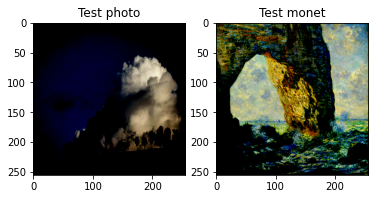

In [29]:
test_monet = next(iter(monet_ds))
test_photo = next(iter(photo_ds))
plt.subplot(1,2,1)
plt.title("Test photo")
plt.imshow(test_photo)
plt.subplot(1,2,2)
plt.title("Test monet")
plt.imshow(test_monet)

### Get Scores Array for all pairs

In [32]:
try:
  scores = np.load("./Score.npy")
except:
  print("Get Scores for each pair")
  for i, m in enumerate(monet_ds):
    if i != 24:
      continue
    for j, n in enumerate(photo_ds):
      scores[i][j] = measure.compare_ssim(m.numpy(), n.numpy(), multichannel=True)
    if ((i+1)%25) == 0:
      np.save("Score"+str(i-24)+'-'+str(i), scores[i-24:i])
      files.download("./Score"+str(i-24)+'-'+str(i)+'.npy') 
    print("Current monet idx: ", i)
  np.save('Score', scores)
  files.download('Score.npy')   

In [33]:
EPOCH = 30
photo_loader_index = np.zeros((monet_len, EPOCH))
for i in range(scores.shape[0]):
  photo_loader_index[i] = np.flip(np.argsort(scores[i]))[0:EPOCH]

In [34]:
for i in range(300):
  photo_related = np.argmax(scores[i])
  print(i, scores[i][photo_related])

0 0.17171703663175408
1 0.16630139593606189
2 0.0515239445939041
3 0.2709131042015118
4 0.17033370506993806
5 0.11955659986921492
6 0.15388699587938537
7 0.19328319675825315
8 0.10087910748791945
9 0.15267543992223997
10 0.07995717459301868
11 0.11930075214040181
12 0.07365032981003464
13 0.1635225689963271
14 0.26161443774154086
15 0.13396972453584563
16 0.11656272128329936
17 0.24703704312163008
18 0.302740911747809
19 0.21258454986341016
20 0.1567481770786273
21 0.2484830659538206
22 0.12066790841726316
23 0.09273955473689897
24 0.16289528338494394
25 0.23941065687969043
26 0.09307073596720267
27 0.17005659600902953
28 0.23231603031281223
29 0.1650992313324758
30 0.21011712826818998
31 0.2634381055019937
32 0.28669261503011806
33 0.2900816895146265
34 0.03724012835052618
35 0.2797845596450333
36 0.1036273658551727
37 0.1813063274114104
38 0.08164787454188029
39 0.32780403449409395
40 0.12580925178585076
41 0.21244802851397168
42 0.11106152572600943
43 0.20455133978153306
44 0.344754

#### Related MonetPainting to Photo

0.27561263112100814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


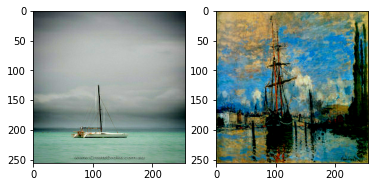

In [36]:
monet_related = 123
photo_related = np.argmax(scores[monet_related])
print(scores[monet_related][photo_related])
idx = 0
for ele in photo_ds:
  if idx==photo_related:
    photo_related = ele
    break
  idx += 1
idx = 0
for ele in monet_ds:
  if idx==monet_related:
     monet_related = ele
     break
  idx += 1
#print(measure.compare_ssim(photo_related.numpy(), monet_related.numpy(), multichannel=True))
plt.title("Related photo to monet")
plt.subplot(1,2,1)
plt.imshow(photo_related)
plt.subplot(1,2,2)
plt.imshow(monet_related)

#### Unelated MonetPainting to Photo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


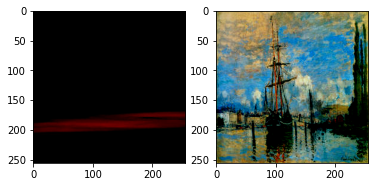

In [37]:
monet_unrelated = 123
photo_unrelated = np.argmin(scores[monet_unrelated])
plt.title("Unrelated photo to monet")
idx = 0
for ele in photo_ds:
  if idx==photo_unrelated:
    photo_unrelated = ele
    break
  idx += 1
idx = 0
for ele in monet_ds:
  if idx==monet_unrelated:
     monet_unrelated = ele
     break
  idx += 1
#print(measure.compare_ssim(photo_unrelated.numpy(), monet_unrelated.numpy(), multichannel=True))
plt.subplot(1,2,1)
plt.imshow(photo_unrelated)
plt.subplot(1,2,2)
plt.imshow(monet_unrelated)

## Cycle-Gan Model

### Network Basics

In [38]:
device = 'cuda'

In [39]:


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc=3, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)



In [40]:
import random
import torch


class ImagePool():
    """This class implements an image buffer that stores previously generated images.

    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class

        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.

        Parameters:
            images: the latest generated images from the generator

        Returns images from the buffer.

        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [41]:
!mkdir checkpoints

In [43]:
class CycleGANModel():

    def __init__(self, isTrain=True):
        """Initialize the CycleGAN class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        global device
        self.isTrain = isTrain
        self.device = torch.device(device)  # get device name: CPU or GPU
        self.save_dir = "checkpoints"  # save all the checkpoints to save_dir
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0 

        ngf = 64
        ndf = 64
        netG = 'resnet_9blocks'
        netD = 'basic'
        input_nc = 3
        output_nc = 3
        pool_size = 50
        lr = 0.0002
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
        if self.isTrain:
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only load Gs
            self.model_names = ['G_A', 'G_B']

        # define networks (both Generators and discriminators)
        # The naming is different from those used in the paper.
        # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
        self.gpu_ids = [0]
        self.netG_A = define_G(input_nc, output_nc, ngf, netG, gpu_ids=self.gpu_ids)
        self.netG_B = define_G(output_nc, input_nc, ngf, netG, gpu_ids=self.gpu_ids)

        if self.isTrain:  # define discriminators
            self.netD_A = define_D(output_nc, ndf, netD, gpu_ids=self.gpu_ids)
            self.netD_B = define_D(input_nc, ndf, netD, gpu_ids=self.gpu_ids)

        if self.isTrain:
            self.fake_A_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
            self.fake_B_pool = ImagePool(pool_size)  # create image buffer to store previously generated images
            # define loss functions
            self.criterionGAN = GANLoss('lsgan').to(self.device)  # define GAN loss.
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=lr, betas=(0.5, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=lr, betas=(0.5, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, inputA, inputB):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap domain A and domain B.
        """
        self.real_A = inputA#.to(self.device)
        self.real_B = inputB#.to(self.device)

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator

        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator

        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = 10
        lambda_A = 0.5
        lambda_B = 0.5
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
    def test(self):
        """Forward function used in test time.

        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            return self.netG_A(self.real_A)

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return self.image_paths

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad



In [44]:
model = CycleGANModel()

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [82]:
torch.cuda.get_device_name('cuda')

'Tesla T4'

In [46]:
transform_list = []
transform_list += [transforms.ToTensor()]
#transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
mytrans = transforms.Compose(transform_list)

## Training Process

In [55]:
allPhotos = [0] * photo_len
for j, ph in enumerate(photo_ds):
    myPh = np.expand_dims(mytrans(ph.numpy()),axis=0)
    allPhotos[j] = torch.as_tensor(myPh).to(device)
allMonets = [0] * monet_len
for j, ph in enumerate(monet_ds):
    myMo = np.expand_dims(mytrans(ph.numpy()),axis=0)
    allMonets[j] = torch.as_tensor(myMo).to(device)

In [48]:
def save_models(epoch):
  global model
  for name in model.model_names:
      if isinstance(name, str):
          save_filename = '%s_net_%s.pth' % (str(epoch), name)
          save_path = os.path.join(model.save_dir, save_filename)
          print(save_path)
          net = getattr(model, 'net' + name)

          torch.save(net.module.cpu().state_dict(), save_path)
          net.cuda(0)
          #files.download(save_path)

In [133]:
def show_images():
  res = None
  global photo_ds, model
  for j, ph in enumerate(photo_ds):
      myPh = np.expand_dims(mytrans(ph.numpy()),axis=0)
      model.set_input(torch.as_tensor(myPh), torch.as_tensor(myPh))
      res = model.netG_B(torch.as_tensor(myPh))
      if j == 1:
        break
  fig = plt.figure(1)
  trans = transforms.ToPILImage()
  fig.add_subplot(1,2,1)
  plt.imshow(ph)
  fig.add_subplot(1,2,2)
  plt.imshow(trans(res[0].cpu()))
  plt.show(True)

In [134]:

def show_10images():
  res = None
  fig = plt.figure(1, figsize=(15,10))
  global photo_ds, model
  for j, ph in enumerate(photo_ds):
      if j < 20:
        continue
      myPh = np.expand_dims(mytrans(ph.numpy()),axis=0)
      model.set_input(torch.as_tensor(myPh), torch.as_tensor(myPh))
      res = model.netG_B(torch.as_tensor(myPh))
      if j == 30:
            break
      j = j - 20
      trans = transforms.ToPILImage()
      fig.add_subplot(4,8,j*2+1)
      plt.imshow(ph)
      plt.axis('off')
      fig.add_subplot(4,8,j*2+2)
      plt.imshow(trans(res[0].cpu()))
      plt.axis('off')
  plt.show(True)

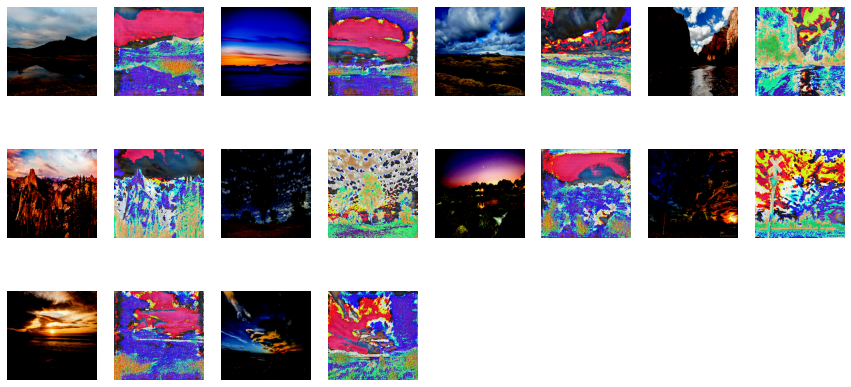

In [135]:
show_10images()

In [104]:
!tar -zcvf ./myModel.zip ./checkpoints/8*

./checkpoints/8_net_D_A.pth
./checkpoints/8_net_D_B.pth
./checkpoints/8_net_G_A.pth
./checkpoints/8_net_G_B.pth


In [105]:
model.load_networks(4)

loading the model from checkpoints/4_net_G_A.pth
loading the model from checkpoints/4_net_G_B.pth
loading the model from checkpoints/4_net_D_A.pth
loading the model from checkpoints/4_net_D_B.pth


Epoch Num:  1 ;;;Current Monet Index:  99 ;;; Alread trained on  12000  Pairs
Epoch Num:  1 ;;;Current Monet Index:  199 ;;; Alread trained on  15000  Pairs
Epoch Num:  1 ;;;Current Monet Index:  299 ;;; Alread trained on  18000  Pairs
checkpoints/1_net_G_A.pth
checkpoints/1_net_G_B.pth
checkpoints/1_net_D_A.pth
checkpoints/1_net_D_B.pth


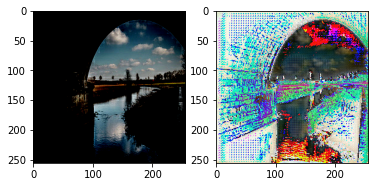

Epoch Num:  2 ;;;Current Monet Index:  99 ;;; Alread trained on  21000  Pairs
Epoch Num:  2 ;;;Current Monet Index:  199 ;;; Alread trained on  24000  Pairs
Epoch Num:  2 ;;;Current Monet Index:  299 ;;; Alread trained on  27000  Pairs
checkpoints/2_net_G_A.pth
checkpoints/2_net_G_B.pth
checkpoints/2_net_D_A.pth
checkpoints/2_net_D_B.pth


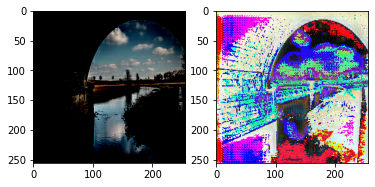

In [ ]:
for e in range(1,30):
  for i, mo in enumerate(monet_ds): 
    myMo = allMonets[i]
    for j in range(photo_len):
      if np.isin(j, photo_loader_index[i]):
        myPh = allPhotos[j]
        model.set_input(myMo, myPh)
        model.optimize_parameters()
    if ((i+1)%100) == 0:
        print("Epoch Num: ", e, ";;;Current Monet Index: ", i, ";;; Alread trained on ", (i+1)*EPOCH + e*300*30, " Pairs")
  save_models(e)
  show_images()

Epoch Num:  5 ;;;Current Monet Index:  99 ;;; Alread trained on  48000  Pairs
Epoch Num:  5 ;;;Current Monet Index:  199 ;;; Alread trained on  51000  Pairs
Epoch Num:  5 ;;;Current Monet Index:  299 ;;; Alread trained on  54000  Pairs
checkpoints/5_net_G_A.pth
checkpoints/5_net_G_B.pth
checkpoints/5_net_D_A.pth
checkpoints/5_net_D_B.pth


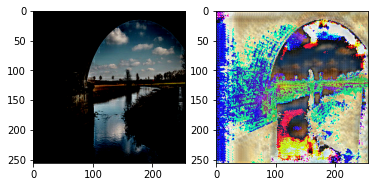

Epoch Num:  6 ;;;Current Monet Index:  99 ;;; Alread trained on  57000  Pairs
Epoch Num:  6 ;;;Current Monet Index:  199 ;;; Alread trained on  60000  Pairs
Epoch Num:  6 ;;;Current Monet Index:  299 ;;; Alread trained on  63000  Pairs
checkpoints/6_net_G_A.pth
checkpoints/6_net_G_B.pth
checkpoints/6_net_D_A.pth
checkpoints/6_net_D_B.pth


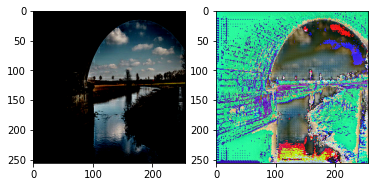

Epoch Num:  7 ;;;Current Monet Index:  99 ;;; Alread trained on  66000  Pairs
Epoch Num:  7 ;;;Current Monet Index:  199 ;;; Alread trained on  69000  Pairs


In [ ]:
for e in range(5,30):
  for i, mo in enumerate(monet_ds): 
    myMo = allMonets[i]
    for j in range(photo_len):
      if np.isin(j, photo_loader_index[i]):
        myPh = allPhotos[j]
        model.set_input(myMo, myPh)
        model.optimize_parameters()
    if ((i+1)%100) == 0:
        print("Epoch Num: ", e, ";;;Current Monet Index: ", i, ";;; Alread trained on ", (i+1)*EPOCH + e*300*30, " Pairs")
  save_models(e)
  show_images()

Epoch Num:  7 ;;;Current Monet Index:  99 ;;; Alread trained on  66000  Pairs
Epoch Num:  7 ;;;Current Monet Index:  199 ;;; Alread trained on  69000  Pairs
Epoch Num:  7 ;;;Current Monet Index:  299 ;;; Alread trained on  72000  Pairs
checkpoints/7_net_G_A.pth
checkpoints/7_net_G_B.pth
checkpoints/7_net_D_A.pth
checkpoints/7_net_D_B.pth


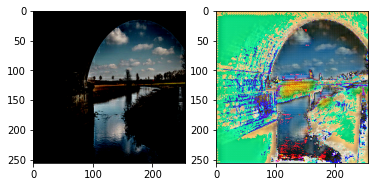

Epoch Num:  8 ;;;Current Monet Index:  99 ;;; Alread trained on  75000  Pairs
Epoch Num:  8 ;;;Current Monet Index:  199 ;;; Alread trained on  78000  Pairs
Epoch Num:  8 ;;;Current Monet Index:  299 ;;; Alread trained on  81000  Pairs
checkpoints/8_net_G_A.pth
checkpoints/8_net_G_B.pth
checkpoints/8_net_D_A.pth
checkpoints/8_net_D_B.pth


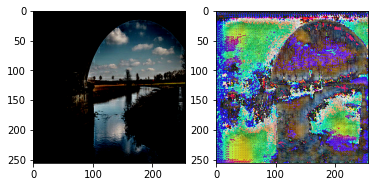

KeyboardInterrupt: 

In [103]:
for e in range(7,30):
  for i, mo in enumerate(monet_ds): 
    myMo = allMonets[i]
    for j in range(photo_len):
      if np.isin(j, photo_loader_index[i]):
        myPh = allPhotos[j]
        model.set_input(myMo, myPh)
        model.optimize_parameters()
    if ((i+1)%100) == 0:
        print("Epoch Num: ", e, ";;;Current Monet Index: ", i, ";;; Alread trained on ", (i+1)*EPOCH + e*300*30, " Pairs")
  save_models(e)
  show_images()

In [79]:
model

## Evaluation Process

In [ ]:
res = None
for j, ph in enumerate(photo_ds):
    myPh = np.expand_dims(mytrans(ph.numpy()),axis=0)
    model.set_input(torch.as_tensor(myPh), torch.as_tensor(myPh))
    res = model.netG_B(torch.as_tensor(myPh))
    if j == 1:
      break
fig = plt.figure(1)
trans = transforms.ToPILImage()
fig.add_subplot(1,2,1)
plt.imshow(ph)
fig.add_subplot(1,2,2)
plt.imshow(trans(res[0]))
plt.show()
